In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\lenovo ssd\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('../Data/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [4]:
df.columns= ['production']

In [7]:
df.head()

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


<Axes: xlabel='DATE'>

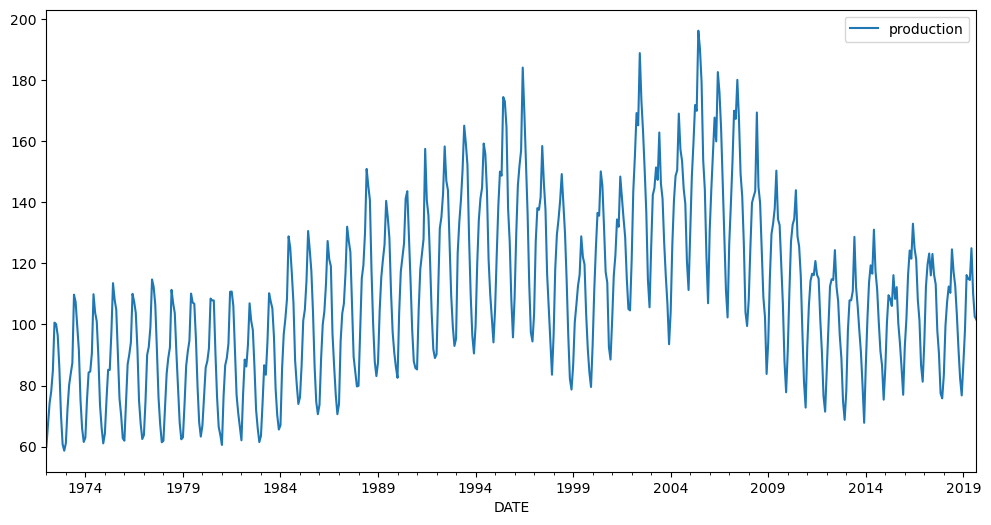

In [8]:
df.plot(figsize=(12,6))

In [9]:
len(df)

573

In [10]:
test_size = 24
test_ind = len(df)-test_size

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
len(test)

24

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM


In [23]:

# Define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features), return_sequences=True))  # First LSTM layer
model.add(LSTM(50, activation='relu'))  # Second LSTM layer (No need for input_shape)

model.add(Dense(1))  # Output layer
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 18, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [35]:
# fit model
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   )

Epoch 1/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0071 - val_loss: 0.0017
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 3/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0050 - val_loss: 0.0121
Epoch 4/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 5/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 6/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 7/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 8/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 9/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0026 - val_loss: 0.0098
Epoch 10/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 11/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 12/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 5s 9m

In [36]:
loss = pd.DataFrame(model.history.history)

<Axes: >

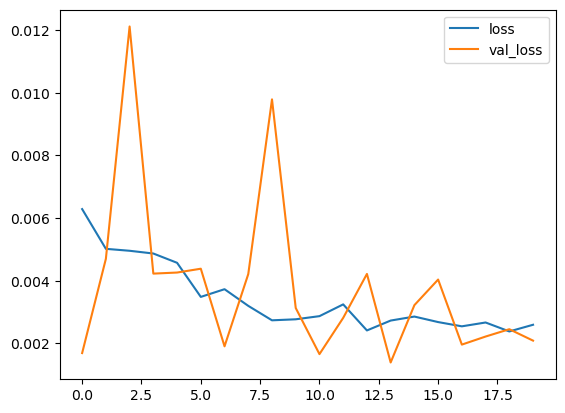

In [37]:
loss.plot()

In [38]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [39]:
true_predictions = scaler.inverse_transform(test_predictions)

In [40]:
test['Predictions'] = true_predictions

C:\Users\lenovo ssd\AppData\Local\Temp\ipykernel_27416\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [41]:
test

,production,Predictions
DATE,,
2017-10-01,90.4732,89.964020
2017-11-01,77.4378,83.183040
2017-12-01,75.8118,83.466791
2018-01-01,83.4343,95.123960
2018-02-01,99.4899,106.764358
2018-03-01,107.3152,113.028942
2018-04-01,112.4309,118.262731
2018-05-01,110.3544,122.180871
2018-06-01,124.5841,123.025214


<Axes: xlabel='DATE'>

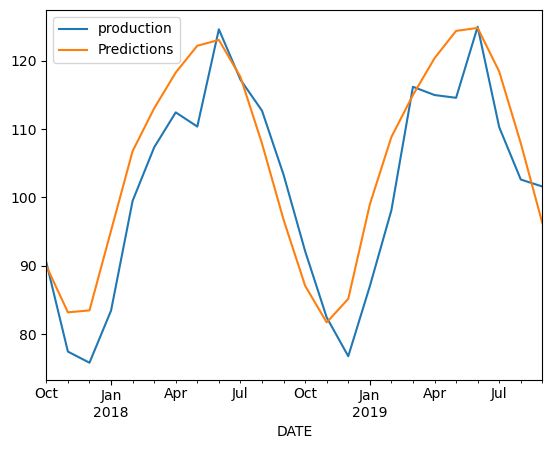

In [42]:
test.plot()